In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.5.1 True
12.4
NVIDIA A40


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
def ou_process_1d(theta=1, mu=0, sigma=1, X0=0, n_steps=10000, n_eval=200, h=1e-5):
    """
    Simulates the Ornstein-Uhlenbeck process.
    
    Parameters:
    - theta: rate of mean reversion
    - mu: long-term mean of the process
    - sigma: volatility
    - X0: initial value
    - n_steps: number of steps in each evaluation
    - n_eval: number of evaluations
    - h: Integration step size
    
    Returns:
    - A numpy array containing the simulated values at each evaluation
    """
    X_eval = np.zeros(n_eval)
    X = X0
    
    for i in range(n_eval):
        for _ in range(n_steps):
            dW = np.sqrt(h) * np.random.randn()
            X = X + theta * (mu - X) * h + sigma * dW
        X_eval[i] = X
    
    return X_eval

## Setup the parameters
theta = 1
mu = 0
sigma = 0.1

In [4]:
# Generate m initial points from the domain space [-2, 2]
m = 10
n_eval = 200
n_steps = 1000
h = 1e-4
lag_time = n_steps * h
print("lag time: ", lag_time)
X0_values = np.linspace(-2, 2, m)

# Initialize the data_matrix
data_matrix = np.zeros((m, n_eval+1, 1))

# Simulate trajectories for each initial point and store them in the data_matrix
for i, X0 in tqdm(enumerate(X0_values), total=m, desc="Simulating trajectories"):
    X_eval = np.concatenate(([X0], ou_process_1d(X0=X0, n_steps=n_steps, n_eval=n_eval, h=h)))
    data_matrix[i, :, 0] = X_eval

# Print the shape of data_matrix
print("Shape of data_matrix:", data_matrix.shape)

# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

lag time:  0.1


Simulating trajectories: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]

Shape of data_matrix: (10, 201, 1)
Shape of data_X: (10, 200, 1)
Shape of data_Y: (10, 200, 1)
Shape of X: (2000, 1)
Shape of Y: (2000, 1)
(1400, 1)


In [ ]:
checkpoint_file= 'ou1d_example_ckpt002.torch'

from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch

basis_function = KoopmanNNTorch(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch', a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32, delta_t= lag_time)

data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [6]:
solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.381177 val loss: 0.358524
saving, val loss enhanced: 0.35852432567747616 10000
Epoch: 2 	Training Loss: 0.378947 val loss: 0.352829
saving, val loss enhanced: 0.3528286099560302 0.35852432567747616
Epoch: 3 	Training Loss: 0.371638 val loss: 0.348406
saving, val loss enhanced: 0.3484064369094016 0.3528286099560302
Epoch: 4 	Training Loss: 0.365213 val loss: 0.342547
saving, val loss enhanced: 0.3425466482149528 0.3484064369094016
Epoch: 5 	Training Loss: 0.357710 val loss: 0.334849
saving, val loss enhanced: 0.3348488525431707 0.3425466482149528
Epoch: 6 	Training Loss: 0.351675 val loss: 0.329525
saving, val loss enhanced: 0.32952514571905095 0.3348488525431707
Epoch: 7 	Training Loss: 0.347550 val loss: 0.325192
saving, val loss enhanced: 0.32519162272603597 0.32952514571905095
Epoch: 8 	Training Loss: 0.341049 val loss: 0.318092
saving, val loss enhanced: 0.3180919073330575 0.32519162272603597
Epoch: 9 	Training Loss: 0.334079 val loss: 0.312984
saving, va

Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7776.22iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_ou.jbl
Outer Epoch 1/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:04<00:00, 6793.66iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 105720.096688 val loss: 109696.333537
saving, val loss enhanced: 109696.33353670352 1000000000000000.0
Epoch: 2 	Training Loss: 105396.329692 val loss: 109362.218036
saving, val loss enhanced: 109362.21803591927 109696.33353670352
Epoch: 3 	Training Loss: 105077.462419 val loss: 109029.903561
saving, val loss enhanced: 109029.90356104787 109362.21803591927


/workspace/solver_edmd_torch_gpu_sde.py:300: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch: 4 	Training Loss: 104760.059106 val loss: 108698.712218
saving, val loss enhanced: 108698.71221820715 109029.90356104787
Epoch 1 time: 9.28 seconds
Outer Epoch 2/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7133.53iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 114719.389633 val loss: 119026.527062
Epoch: 2 	Training Loss: 114366.926922 val loss: 118655.767244
Epoch: 3 	Training Loss: 114011.956712 val loss: 118284.391420
Epoch: 4 	Training Loss: 113657.046292 val loss: 117913.966129
Epoch 2 time: 9.02 seconds
Outer Epoch 3/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7131.11iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 123451.514791 val loss: 128068.145408
Epoch: 2 	Training Loss: 123060.018645 val loss: 127656.211555
Epoch: 3 	Training Loss: 122665.646941 val loss: 127243.787771
Epoch: 4 	Training Loss: 122271.647978 val loss: 126832.917009
Epoch 3 time: 9.23 seconds
Outer Epoch 4/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7576.84iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 132657.100299 val loss: 137597.557710
Epoch: 2 	Training Loss: 132223.474355 val loss: 137141.369340
Epoch: 3 	Training Loss: 131786.794188 val loss: 136684.907012
Epoch: 4 	Training Loss: 131350.837121 val loss: 136230.566443
Epoch 4 time: 9.10 seconds
Outer Epoch 5/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7063.20iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 141194.299214 val loss: 146431.625705
Epoch: 2 	Training Loss: 140721.028923 val loss: 145934.433283
Epoch: 3 	Training Loss: 140245.335238 val loss: 145437.603317
Epoch: 4 	Training Loss: 139770.967693 val loss: 144943.519752
Epoch 5 time: 9.40 seconds
Outer Epoch 6/6


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 7074.94iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 149380.962350 val loss: 154901.289978
Epoch: 2 	Training Loss: 148870.681627 val loss: 154365.710604
Epoch: 3 	Training Loss: 148358.406030 val loss: 153830.937776
Epoch: 4 	Training Loss: 147847.883303 val loss: 153299.364072
Epoch 6 time: 9.18 seconds


/workspace/solver_edmd_torch_gpu_sde.py:684: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


In [7]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Koopman_matrix_K = solver.K
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict,
    'K': Koopman_matrix_K
    }

[-3.64451787e-05+0.j -8.91180747e-01+0.j -1.96482237e+00+0.j
 -3.02185781e+00+0.j]


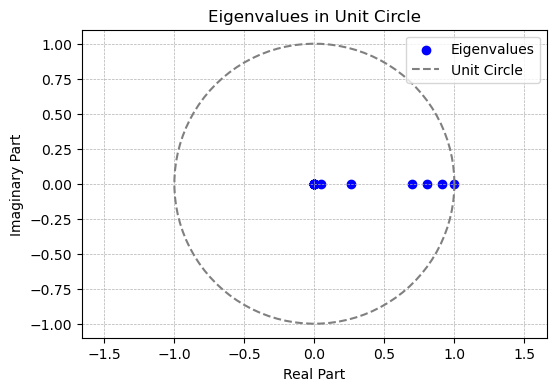

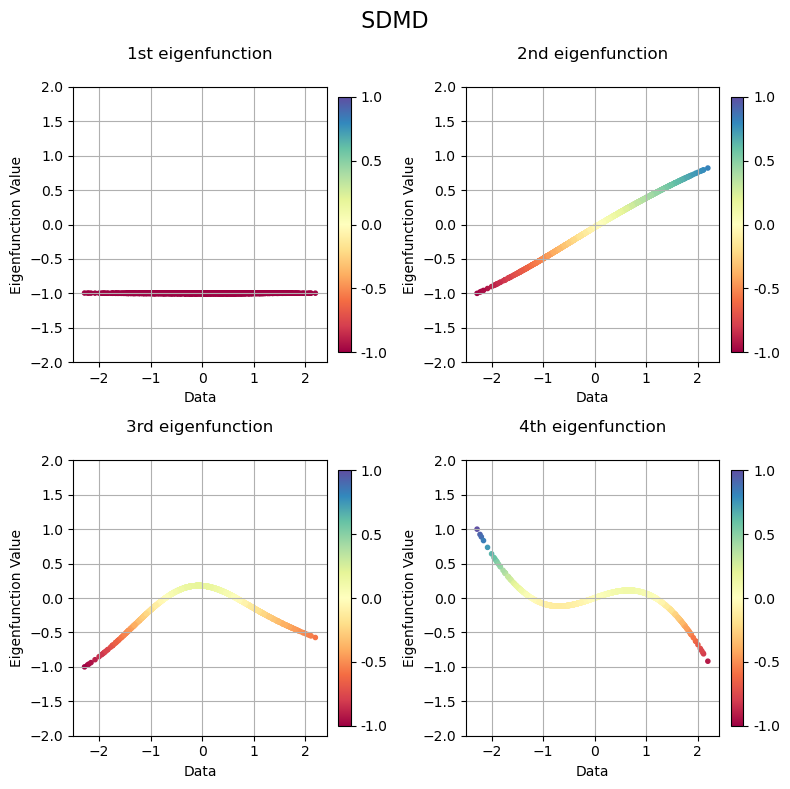

In [8]:
# Take ln values of the eigenvalues and divide by 0.1
# ln_evalues = np.log(evalues[:4]) / lag_time
ln_evalues = (evalues[:4]-1) / lag_time

print(ln_evalues)

## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' SDMD ', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
basis_function_g = KoopmanNNTorch_g(input_size=1, layer_sizes=[20, 20], n_psi_train=18).to(device)

solver_g = KoopmanSolverTorch_g(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                       reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn_ou_001.torch',  a_b_file= 'a_b_example_ou.jbl',
                generator_batch_size= 4, fnn_batch_size= 32)

In [10]:
solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=32,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8,   
    )

Precomputed SDE coefficients loaded from: a_b_example_ou.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8847.81iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
Outer Epoch 1/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 8968.69iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9068.95iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9224.85iteration/s]


Epoch: 1 	Training Loss: 13.418846 val loss: 13.775178
saving, val loss enhanced: 13.775178271580538 1000000000000000.0
Epoch: 2 	Training Loss: 13.105173 val loss: 13.454335
saving, val loss enhanced: 13.454334671523176 13.775178271580538
Epoch: 3 	Training Loss: 12.802238 val loss: 13.140875
saving, val loss enhanced: 13.140874694252377 13.454334671523176
Epoch: 4 	Training Loss: 12.505956 val loss: 12.834420
saving, val loss enhanced: 12.834419778144303 13.140874694252377


/workspace/solver_gedmd_torch_gpu.py:309: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Epoch 1 time: 18.21 seconds
Outer Epoch 2/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9179.37iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9167.08iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9556.66iteration/s]


Epoch: 1 	Training Loss: 11.649762 val loss: 11.965391
saving, val loss enhanced: 11.965391116385538 12.834419778144303
Epoch: 2 	Training Loss: 11.407063 val loss: 11.713340
saving, val loss enhanced: 11.713339736320604 11.965391116385538
Epoch: 3 	Training Loss: 11.167295 val loss: 11.463986
saving, val loss enhanced: 11.463986408699189 11.713339736320604
Epoch: 4 	Training Loss: 10.930305 val loss: 11.217847
saving, val loss enhanced: 11.217847427089401 11.463986408699189
Epoch 2 time: 17.58 seconds
Outer Epoch 3/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9249.73iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9391.33iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8079.52iteration/s]


Epoch: 1 	Training Loss: 10.240500 val loss: 10.522365
saving, val loss enhanced: 10.522364814177207 11.217847427089401
Epoch: 2 	Training Loss: 10.041744 val loss: 10.315899
saving, val loss enhanced: 10.315898829815671 10.522364814177207
Epoch: 3 	Training Loss: 9.845117 val loss: 10.111226
saving, val loss enhanced: 10.111225585547528 10.315898829815671
Epoch: 4 	Training Loss: 9.650288 val loss: 9.908599
saving, val loss enhanced: 9.908599170880365 10.111225585547528
Epoch 3 time: 19.05 seconds
Outer Epoch 4/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9192.21iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9611.14iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 8029.43iteration/s]


Epoch: 1 	Training Loss: 9.104879 val loss: 9.360035
saving, val loss enhanced: 9.360035344774259 9.908599170880365
Epoch: 2 	Training Loss: 8.939045 val loss: 9.187675
saving, val loss enhanced: 9.187675343141544 9.360035344774259
Epoch: 3 	Training Loss: 8.774766 val loss: 9.016556
saving, val loss enhanced: 9.016556233623543 9.187675343141544
Epoch: 4 	Training Loss: 8.611710 val loss: 8.846817
saving, val loss enhanced: 8.846816506914905 9.016556233623543
Epoch 4 time: 19.80 seconds
Outer Epoch 5/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9216.72iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:02<00:00, 9551.08iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9380.39iteration/s]


Epoch: 1 	Training Loss: 8.161900 val loss: 8.395172
saving, val loss enhanced: 8.395172319148848 8.846816506914905
Epoch: 2 	Training Loss: 8.021969 val loss: 8.249650
saving, val loss enhanced: 8.249649626147523 8.395172319148848
Epoch: 3 	Training Loss: 7.883165 val loss: 8.104971
saving, val loss enhanced: 8.104970943957214 8.249649626147523
Epoch: 4 	Training Loss: 7.745185 val loss: 7.961220
saving, val loss enhanced: 7.961220482115982 8.104970943957214
Epoch 5 time: 18.92 seconds
Outer Epoch 6/6
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9025.44iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9186.61iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 11960/11960 [00:01<00:00, 9453.14iteration/s]


Epoch: 1 	Training Loss: 7.342175 val loss: 7.556981
saving, val loss enhanced: 7.556980989254316 7.961220482115982
Epoch: 2 	Training Loss: 7.223819 val loss: 7.433825
saving, val loss enhanced: 7.433825019117472 7.556980989254316
Epoch: 3 	Training Loss: 7.106262 val loss: 7.311203
saving, val loss enhanced: 7.311202818374969 7.433825019117472


/workspace/solver_gedmd_torch_gpu.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.checkpoint_file)


Epoch: 4 	Training Loss: 6.989223 val loss: 7.189171
saving, val loss enhanced: 7.189171278387426 7.311202818374969
Epoch 6 time: 19.53 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 27980/27980 [00:03<00:00, 9198.57iteration/s]


dPsi_X shape:  torch.Size([1399, 20])
psi_x shape:  torch.Size([1399, 20])
psi_x_inv shape:  torch.Size([20, 1399])
cuda:0
cuda:0


In [11]:
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'N_dict': N_dict
    }

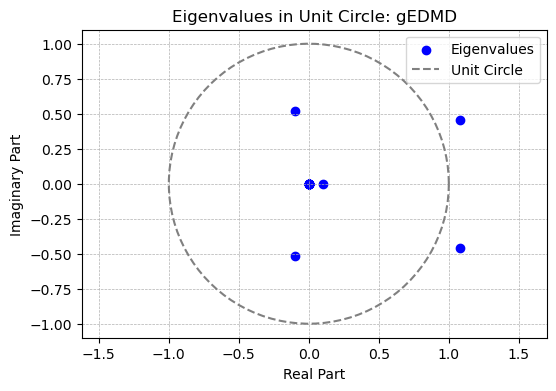

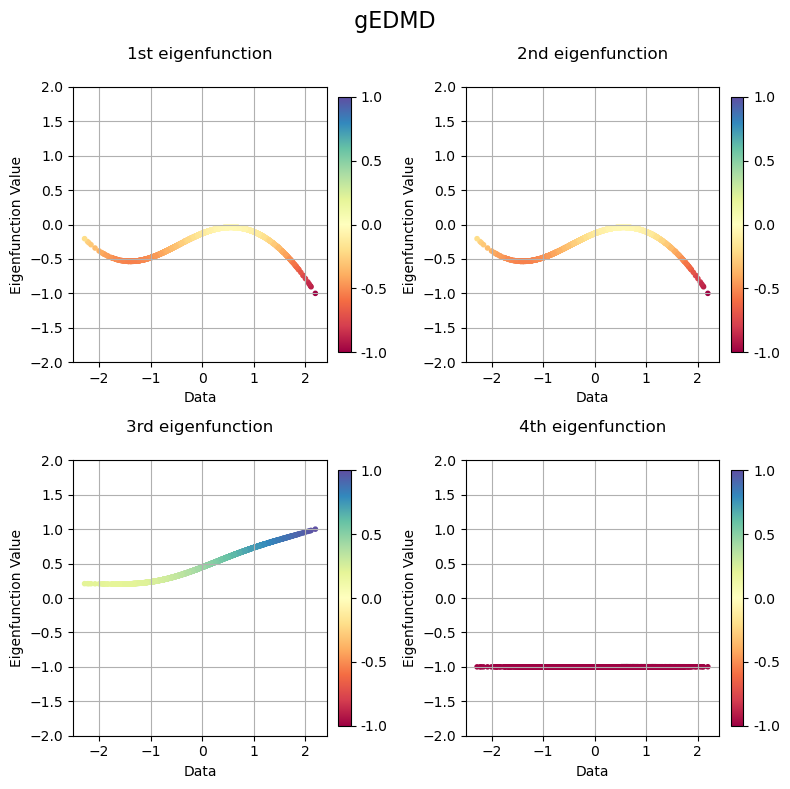

In [12]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

## Plot eigenfunctions
# Get the real part of eigenfunctions and normalize them
phi = np.real(efuns)

# Use the entire efuns instead of slicing
for i in range(len(evalues)):
    phi[:, i] = phi[:, i] / np.max(np.abs(phi[:, i]))

# Create a plot with 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
titles = ['1st eigenfunction', '2nd eigenfunction', '3rd eigenfunction', '4th eigenfunction']

# Determine global min and max values for the eigenfunctions for a uniform scale
vmin = np.min(phi)
vmax = np.max(phi)
cbar_ticks = np.linspace(vmin, vmax, 5)

# Flatten the 2D array of axes for easy iteration
axs_flat = axs.flatten()

for i, (ax, title) in enumerate(zip(axs_flat, titles)):
    scatter = ax.scatter(X, phi[:, i], c=phi[:, i], cmap='Spectral', marker='.', vmin=vmin, vmax=vmax)
    ax.set_title(title, pad=20)
    ax.set_xlabel('Data')
    ax.set_ylabel('Eigenfunction Value')
    ax.set_ylim(-2, 2)
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=cbar_ticks)
    cbar.set_ticklabels([f"{tick:.1f}" for tick in cbar_ticks])
    ax.grid()
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()